In [1]:
import torch, cv2, copy
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
from typing import Iterable
from torchvision.models.resnet import BasicBlock, Bottleneck
from data_preparation.dataset import FrameDataset
from model.architecture import GWDetectionNET
from metrics import GWDetectionCriterion
from pipelines import BBoxExclusiveTrainingPipeline, SegmentExclusiveTrainingPipeline, TrainingPipeline
from matplotlib import pyplot as plt

In [2]:
def prepare_img_and_bbox(
        img: torch.Tensor, 
        bbox: torch.Tensor, 
        scaled_bbox: bool=True,
        xy_centered: bool=True):
    img = (img * 255).type(torch.uint8).squeeze().numpy()

    if bbox.shape[0] == 4:
        x, y, w, h = bbox
    else:
        _, x, y, w, h = bbox

    if scaled_bbox:
        x *= img.shape[1]
        y *= img.shape[0]
        w *= img.shape[1]
        h *= img.shape[0]

    if xy_centered:
        x = x-(w/2)
        y = y-(h/2)
    bbox = np.array([x, y, w, h]).astype(int)
    return img, bbox

def draw_bbox(img :np.ndarray, bbox: Iterable[int], single_channel: bool=True):
    if bbox.shape[0] == 4:
        x, y, w, h = bbox
    else:
        _, x, y, w, h = bbox
    ch = (0, 200, 90) if not single_channel else (255)
    return cv2.rectangle(img, (x, y), (x+w, y+h), ch, 1)


In [3]:
train_data_path = "data/Train_data"
validation_data_path = "data/Validation_data"
test_data_path = "data/Test_data"
img_size = (256, 256)

train_dataset = FrameDataset(train_data_path, grayscale=True, img_loc="png", mask_loc="gt", size=img_size)
validation_dataset = FrameDataset(validation_data_path, grayscale=True, size=img_size)
test_dataset = FrameDataset(test_data_path, grayscale=True, size=img_size)

Sample Images (shape: torch.Size([1, 256, 256]))


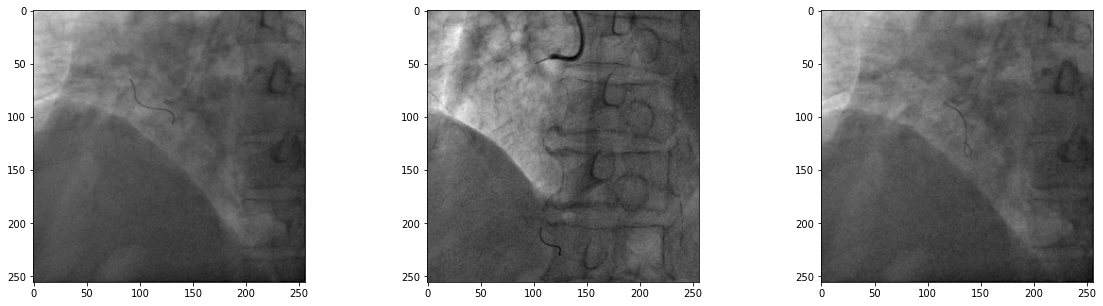


Sample Images with Bounding Boxes


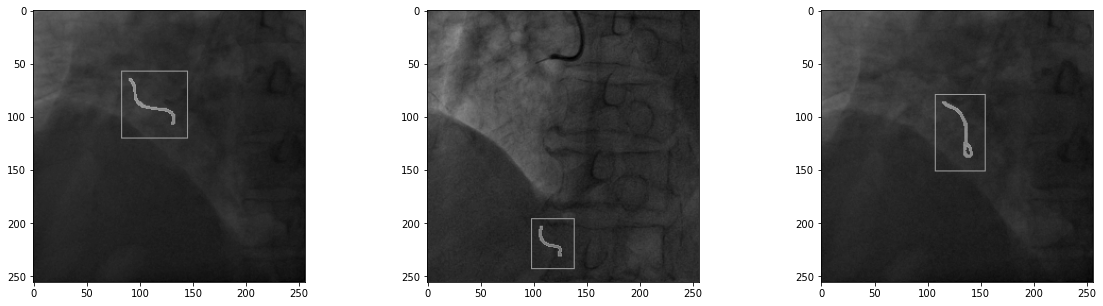

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
train_sample_img, train_sample_bbox, train_sample_mask = train_dataset[120]
val_sampl_img, val_sampl_bbox, val_sample_mask = validation_dataset[220]
test_sample_img, test_sample_bbox, test_sample_mask = test_dataset[198]

print(f"Sample Images (shape: {train_sample_img.shape})")
axs[0].imshow(train_sample_img.squeeze(), cmap="gray")
axs[1].imshow(val_sampl_img.squeeze(), cmap="gray")
axs[2].imshow(test_sample_img.squeeze(), cmap="gray")
plt.show()

train_sample_img, train_sample_bbox = prepare_img_and_bbox(train_sample_img, train_sample_bbox)
val_sampl_img, val_sampl_bbox = prepare_img_and_bbox(val_sampl_img, val_sampl_bbox)
test_sample_img, test_sample_bbox = prepare_img_and_bbox(test_sample_img, test_sample_bbox)

bbox_train_sample_img = draw_bbox(copy.deepcopy(train_sample_img), train_sample_bbox)
bbox_val_sampl_img = draw_bbox(copy.deepcopy(val_sampl_img), val_sampl_bbox)
bbox_test_sample_img = draw_bbox(copy.deepcopy(test_sample_img), test_sample_bbox)

print("\nSample Images with Bounding Boxes")
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(bbox_train_sample_img, cmap="gray")
axs[0].imshow(train_sample_mask.squeeze(), alpha=0.4, cmap="gray")

axs[1].imshow(bbox_val_sampl_img, cmap="gray")
axs[1].imshow(val_sample_mask.squeeze(), alpha=0.4, cmap="gray")

axs[2].imshow(bbox_test_sample_img, cmap="gray")
axs[2].imshow(test_sample_mask.squeeze(), alpha=0.4, cmap="gray")
plt.show()


In [ ]:
batch_size = 32
num_workers = 2

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [ ]:
# model params
in_channels = 1
n_classes = 0
dropout = 0.2
block = BasicBlock
block_layers = [2, 2, 2, 2]
pretrained_backbone = None #"resnet18"
last_fmap_ch = 512
anchor_path = "anchors/anchors.json"

# loss function params
iou_threshold = 0.5

# optimizer params
lr = 1e-3
min_lr = 1e-6
weight_decay = 7e-6
betas = (0.9, 0.9999)
T_0 = 20
T_mult = 2

# pipeline params
device = "cuda" if torch.cuda.is_available() else "cpu"
model_folder = "saved_model"
model_name = f"gw_detection_model.pth.tar"

In [ ]:
torch.manual_seed(3407)
torch.cuda.manual_seed(3407)
np.random.seed(3407)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
model = GWDetectionNET(
    in_channels, 
    img_size=img_size,
    anchors_path=anchor_path, 
    n_classes=n_classes, 
    block=block, 
    block_layers=block_layers,
    pretrained_resnet_backbone=pretrained_backbone, 
    last_fmap_ch=last_fmap_ch,
    use_locnet=True,
    use_segnet=True
    )
bbox_lossfunc = GWDetectionCriterion(iou_threshold=iou_threshold)
mask_lossfunc = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas, weight_decay=weight_decay)

# training pipeline
train_pipeline = TrainingPipeline(
    model=model, 
    bbox_lossfunc=bbox_lossfunc,
    mask_lossfunc=mask_lossfunc,
    optimizer=optimizer,
    device=device, 
    dirname=model_folder, 
    filename=model_name,
)

# lr scheduler
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    train_pipeline.optimizer, T_0=T_0, T_mult=T_mult, eta_min=min_lr, verbose=True,
)

In [ ]:
epochs = 60

import warnings
warnings.filterwarnings("ignore")

for epoch in range(epochs):
    print(f"epoch: {epoch+1} / {epochs}")
    train_pipeline.train(train_dataloader, verbose=True)
    train_pipeline.evaluate(validation_dataloader, verbose=True)
    lr_scheduler.step()
    print("-"*130)

train_pipeline.plot_metrics("train")
train_pipeline.plot_metrics("eval")